# PRAD model extension testing

Here we test what happens to the original models if we start adding features

In [29]:
library(tidyverse)
library(survival)
library(survminer)
library(glmnet)
library(WriteXLS)
library(ggfortify)
library(circlize)
library(ComplexHeatmap)
library(parallel)
library(broom)
library(survcomp)
library(survivalROC)
library(gtsummary)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")

## Functions 

In [30]:
#
#
#
# Helper function for fixing variable names 
fixVarNames = function(x){
    print(x[1])
    if (str_detect(x, "Gender.clin")) {
        return("Gender")
    } else if (str_detect(x, "Tumor.stage.clin")){
        return("Tumor.stage")
    } else if (str_detect(x,".cn")){
        return(str_extract(x, "\\w+.cn"))
    } else if (str_detect(x, "Gleason.group.clin")){ 
        return("Gleason.group.clin")
    } else {
        return(x)
    }
}


# 
# Function fits a cox regression model
# 
fitCoxModel = function(data, end.point, features){
    
    # Expand to variable name
    end_point_time = paste0(end.point, ".time.clin")
    end_point_event = paste0(end.point, ".clin")

    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, paste(features, collapse = " + "), sep = " ~ "))
    
    model.fit = coxph(f, data = data)
    return(model.fit)
}

## Load processed data

In [31]:
tcga.dataset.merged = readRDS("/lustre/projects/landstrom_core/data/rdata_revised/manuscript_work//PRAD//tcga.dataset_merged.rds")

## Load original model and extracting features

In [105]:
# Loading original features 
original.model.features = read_excel("/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type/PRAD/Penalized_Cox_risk_prediction/customer_features/With_clinical_features/PFI/Active_covariates_in_lambda.min_model.xlsx")

New names:
• `` -> `...1`


In [106]:
# Feature names to be selected 
selected.features = map_chr(unlist(original.model.features[,1]), fixVarNames) %>% as.vector()

[1] "Age.clin"
[1] "Gleason.group.clinGleason_group_2"
[1] "KIF23.exp"
[1] "PTEN.exp"
[1] "VPS4B.exp"
[1] "AURKA.exp"
[1] "AURKB.exp"
[1] "TP53.cn-1"


## Refitting the original model using standard cox-regression

In [107]:
# Construct the clinical end points 
end_point_event = paste0("PFI", ".clin")
end_point_time = paste0("PFI", ".time.clin")
    
selected.columns = c(end_point_event, end_point_time, selected.features)

In [108]:
# Input data for cox-model 
input.training = tcga.dataset.merged[["PFI"]]$train %>% dplyr::select(all_of(selected.columns))

# Fit the cox-model 
pcox.ref.fit.pfi.original = fitCoxModel(input.training, "PFI", selected.features)

# Predict the risk scores for validation data 
rel.risk = predict(object = pcox.ref.fit.pfi.original, 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features], 
                   type = "risk")

#
# Evaluate 
#

# Stratify validation data into two groups based on the fitted relative risk
y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
colnames(y.data) = c("status","time")

# TEST new function for calculating the C-index
cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

# Plot KM and extract the p-value  
KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)

In [109]:
# Modify the labels 

colnames(tcga.dataset.merged[["PFI"]]$train) = str_replace(colnames(tcga.dataset.merged[["PFI"]]$train), "-", "_")
colnames(tcga.dataset.merged[["PFI"]]$validation) = str_replace(colnames(tcga.dataset.merged[["PFI"]]$validation), "-", "_")

## Load the KM results 

In [37]:
km.results.de = read.csv("/lustre/projects/landstrom_core/results/prognostic_model_development_revised_cell_cycle/DE_based/top300/PRAD/Kaplan_Meier_plots/PFI_LogRank_pvalues.csv")

In [38]:
# Convert "-" to &
km.results.de$Feature = str_replace(km.results.de$Feature, "-", "_")

## TEST SINGLE GENE

[1] 0.6749079
$Plot

$table
    N Pvalue.variable Pvalue.pval Pvalue.method Pvalue.pval.txt
1 121           group 0.004557709      Log-rank      p = 0.0046



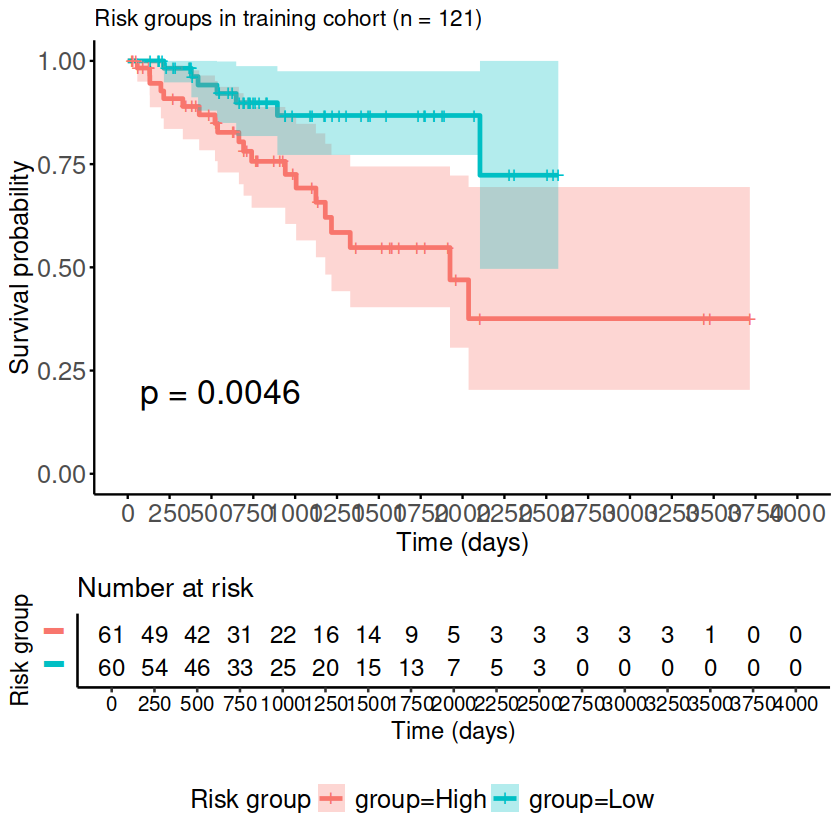

In [39]:
new.feature = "FAM72A.exp"

# Test adding one gene
#selected.columns.test = c(selected.columns, new.feature)

selected.columns.test = c(selected.columns, c(km.results.de$Feature[1], km.results.de$Feature[12],km.results.de$Feature[14], 
                                              km.results.de$Feature[15]))
    
# Input data for cox-model 
input.training = tcga.dataset.merged[["PFI"]]$train %>% dplyr::select(all_of(selected.columns.test))

# The features 
selected.features.test = selected.columns.test[-c(1,2)]
    
# Fit the cox-model 
pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI", selected.features.test)

# Predict the risk scores for validation data 
rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features.test], 
                   type = "risk")

#
# Evaluate 
#

# Stratify validation data into two groups based on the fitted relative risk
y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
colnames(y.data) = c("status","time")

# TEST new function for calculating the C-index
cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

# Plot KM and extract the p-value  
KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
print(cindex.ref.valid$c.index)
#print(KM.valid.ref.by.risk$table)
print(KM.valid.ref.by.risk)

## Step-wise addition of features

In [40]:
selected.columns.stepwise = selected.columns

In [41]:
km.results.de$Feature[1:300] = str_replace(km.results.de$Feature[1:300], ".del", "")

In [42]:
km.results.de$Feature[1:300] = str_replace(km.results.de$Feature[1:300], ".amp", "")

In [43]:
new.genes.exp = km.results.de$Feature[1:300]

In [44]:
# Store results 
step.wise.results = matrix(nrow = 0, ncol = 2) %>% as.data.frame() 
colnames(step.wise.results) = c("KM.pvalue","C.index")

In [45]:
step.wise.results = as.data.frame(lapply(step.wise.results, as.numeric))

In [46]:
for (i in 1:length(new.genes.exp)){
    new.feature = new.genes.exp[i]
    
    # Test adding one gene
    selected.columns.stepwise = c(selected.columns.stepwise, new.feature)
    
    # Input data for cox-model 
    input.training = tcga.dataset.merged[["PFI"]]$train[,colnames(tcga.dataset.merged[["PFI"]]$train) %in% selected.columns.stepwise]

    # The features 
    selected.features.stepwise = selected.columns.stepwise[-c(1,2)]
    
    # Fit the cox-model 
    pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI", selected.features.stepwise)

    # Predict the risk scores for validation data 
    rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features.stepwise], 
                   type = "risk")

    #
    # Evaluate 
    #

    # Stratify validation data into two groups based on the fitted relative risk
    y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
    colnames(y.data) = c("status","time")

    # TEST new function for calculating the C-index
    cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

    # Plot KM and extract the p-value  
    KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
    res = data.frame(KM.pvalue = KM.valid.ref.by.risk$table$Pvalue.pval,
                     C.index = cindex.ref.valid$c.index,
                     "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                round(cindex.ref.valid$upper, 4), ")")
                     )
    step.wise.results = rbind(step.wise.results, res)
    
    #print(cindex.ref.valid$c.index)
    #print(KM.valid.ref.by.risk$table)
    
}


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = 

In [47]:
step.wise.results$Iter = seq(1,300)

In [48]:
gg = step.wise.results %>% ggplot(aes(x = Iter, y = -1 * log(KM.pvalue))) + geom_point()

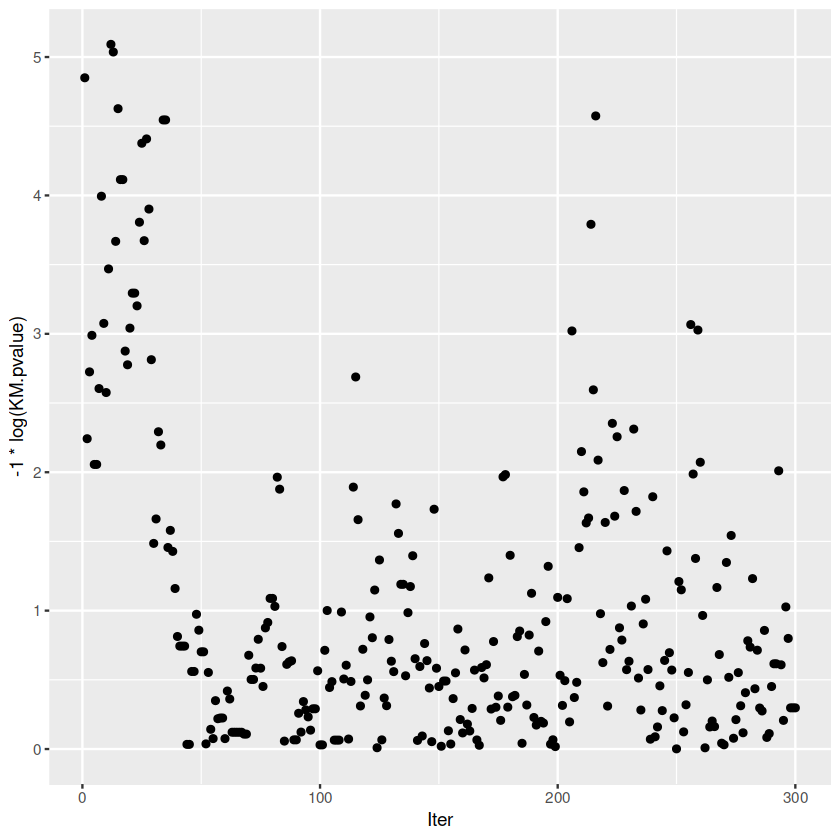

In [49]:
gg

Find the minimal p-value and the corresponding C-index

In [50]:
which(step.wise.results$KM.pvalue == min(step.wise.results$KM.pvalue))

[1] 12

In [51]:
step.wise.results[12,]

,KM.pvalue,C.index,C.index.CI,Iter
,<dbl>,<dbl>,<chr>,<int>
12,0.006148744,0.6801683,(0.436 - 0.854),12


In [115]:
new.genes.exp[1:12]

[1] "CNIH2.exp"           "MXD3.exp"            "ESPL1.exp"          
 [4] "FEZF1_AS1.exp"       "EME1.exp"            "ARHGEF39.exp"       
 [7] "AMH.exp"             "ENSG00000262528.exp" "UBE2T.exp"          
[10] "FMOD.exp"            "TK1.exp"             "MAB21L1.exp"

In [133]:
selected.genes.step2 = new.genes.exp[1:12]

elected.columnsRemove step-wise features 

In [117]:
selected.columns.stepwise = selected.columns

In [118]:
# Store results 
step.wise.results = matrix(nrow = 0, ncol = 2) %>% as.data.frame() 
colnames(step.wise.results) = c("KM.pvalue","C.index")

In [119]:
step.wise.results = as.data.frame(lapply(step.wise.results, as.numeric))

In [120]:
selected.columns

[1] "PFI.clin"           "PFI.time.clin"      "Age.clin"          
 [4] "Gleason.group.clin" "KIF23.exp"          "PTEN.exp"          
 [7] "VPS4B.exp"          "AURKA.exp"          "AURKB.exp"         
[10] "TP53.cn"

In [121]:
selected.genes.step2[-2]

[1] "CNIH2.exp"           "ESPL1.exp"           "FEZF1_AS1.exp"      
 [4] "EME1.exp"            "ARHGEF39.exp"        "AMH.exp"            
 [7] "ENSG00000262528.exp" "UBE2T.exp"           "FMOD.exp"           
[10] "TK1.exp"             "MAB21L1.exp"

In [122]:
selected.columns.stepwise

[1] "PFI.clin"           "PFI.time.clin"      "Age.clin"          
 [4] "Gleason.group.clin" "KIF23.exp"          "PTEN.exp"          
 [7] "VPS4B.exp"          "AURKA.exp"          "AURKB.exp"         
[10] "TP53.cn"

In [123]:
for (i in 1:length(selected.genes.step2)){
    #new.feature = new.genes.exp[i]
    
    # Test adding genes except one 
    selected.columns.2 = c(selected.columns.stepwise, selected.genes.step2[-1 * i])

    
    # Input data for cox-model 
    input.training = tcga.dataset.merged[["PFI"]]$train[,colnames(tcga.dataset.merged[["PFI"]]$train) %in%  selected.columns.2]

    # The features 
    selected.features = selected.columns.2[-c(1,2)]
    print(selected.features)
    
    # Fit the cox-model 
    pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI",  selected.features)

    # Predict the risk scores for validation data 
    rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features], 
                   type = "risk")

    #
    # Evaluate 
    #

    # Stratify validation data into two groups based on the fitted relative risk
    y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
    colnames(y.data) = c("status","time")

    # TEST new function for calculating the C-index
    cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

    # Plot KM and extract the p-value  
    KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
    res = data.frame(KM.pvalue = KM.valid.ref.by.risk$table$Pvalue.pval,
                     C.index = cindex.ref.valid$c.index,
                     "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                round(cindex.ref.valid$upper, 4), ")")
                     )
    step.wise.results = rbind(step.wise.results, res)
    
    #print(cindex.ref.valid$c.index)
    #print(KM.valid.ref.by.risk$table)
    
}

 [1] "Age.clin"            "Gleason.group.clin"  "KIF23.exp"          
 [4] "PTEN.exp"            "VPS4B.exp"           "AURKA.exp"          
 [7] "AURKB.exp"           "TP53.cn"             "MXD3.exp"           
[10] "ESPL1.exp"           "FEZF1_AS1.exp"       "EME1.exp"           
[13] "ARHGEF39.exp"        "AMH.exp"             "ENSG00000262528.exp"
[16] "UBE2T.exp"           "FMOD.exp"            "TK1.exp"            
[19] "MAB21L1.exp"        
 [1] "Age.clin"            "Gleason.group.clin"  "KIF23.exp"          
 [4] "PTEN.exp"            "VPS4B.exp"           "AURKA.exp"          
 [7] "AURKB.exp"           "TP53.cn"             "CNIH2.exp"          
[10] "ESPL1.exp"           "FEZF1_AS1.exp"       "EME1.exp"           
[13] "ARHGEF39.exp"        "AMH.exp"             "ENSG00000262528.exp"
[16] "UBE2T.exp"           "FMOD.exp"            "TK1.exp"            
[19] "MAB21L1.exp"        
 [1] "Age.clin"            "Gleason.group.clin"  "KIF23.exp"          
 [4] "PTEN.exp"        

In [124]:
step.wise.results

KM.pvalue,C.index,C.index.CI
<dbl>,<dbl>,<chr>
0.002590051,0.6554445,(0.413 - 0.8372)
0.008340319,0.6785902,(0.4345 - 0.853)
0.006968790,0.6838506,(0.4394 - 0.8565)
0.024051977,0.6696476,(0.4261 - 0.8469)
0.006148744,0.6801683,(0.436 - 0.854)
0.007339755,0.6775381,(0.4335 - 0.8523)
0.018520860,0.6717517,(0.4281 - 0.8484)
0.004118272,0.6875329,(0.4429 - 0.8589)
0.006498322,0.6812204,(0.437 - 0.8547)


In [127]:
rem.idx = which(step.wise.results$KM.pvalue == min(step.wise.results$KM.pvalue))

In [134]:
selected.genes.step2 = selected.genes.step2[-1 * rem.idx]

In [139]:
# Store results 
step.wise.results = matrix(nrow = 0, ncol = 2) %>% as.data.frame() 
colnames(step.wise.results) = c("KM.pvalue","C.index")

In [140]:
step.wise.results = as.data.frame(lapply(step.wise.results, as.numeric))

In [141]:
for (i in 1:length(selected.genes.step2)){
    #new.feature = new.genes.exp[i]
    
    # Test adding genes except one 
    selected.columns.2 = c(selected.columns.stepwise, selected.genes.step2[-1 * i])

    
    # Input data for cox-model 
    input.training = tcga.dataset.merged[["PFI"]]$train[,colnames(tcga.dataset.merged[["PFI"]]$train) %in%  selected.columns.2]

    # The features 
    selected.features = selected.columns.2[-c(1,2)]
    
    # Fit the cox-model 
    pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI",  selected.features)

    # Predict the risk scores for validation data 
    rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features], 
                   type = "risk")

    #
    # Evaluate 
    #

    # Stratify validation data into two groups based on the fitted relative risk
    y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
    colnames(y.data) = c("status","time")

    # TEST new function for calculating the C-index
    cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

    # Plot KM and extract the p-value  
    KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
    res = data.frame(KM.pvalue = KM.valid.ref.by.risk$table$Pvalue.pval,
                     C.index = cindex.ref.valid$c.index,
                     "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                round(cindex.ref.valid$upper, 4), ")")
                     )
    step.wise.results = rbind(step.wise.results, res)
    
    #print(cindex.ref.valid$c.index)
    #print(KM.valid.ref.by.risk$table)
    
}

In [142]:
step.wise.results

KM.pvalue,C.index,C.index.CI
<dbl>,<dbl>,<chr>
0.0014433370,0.6317728,(0.3914 - 0.8207)
0.0023557029,0.6622830,(0.4193 - 0.8419)
0.0027896815,0.6459758,(0.4043 - 0.8307)
0.0025900508,0.6596528,(0.4169 - 0.8401)
0.0006275848,0.6496581,(0.4077 - 0.8332)
0.0200747385,0.6486060,(0.4067 - 0.8325)
0.0041182722,0.6638611,(0.4208 - 0.843)
0.0025900508,0.6543924,(0.412 - 0.8365)
0.0041942756,0.6580747,(0.4154 - 0.839)


In [143]:
rem.idx = which(step.wise.results$KM.pvalue == min(step.wise.results$KM.pvalue))

In [144]:
rem.idx

[1] 5

In [145]:
selected.genes.step2 = selected.genes.step2[-1 * rem.idx]

In [146]:
selected.genes.step2 

[1] "MXD3.exp"            "ESPL1.exp"           "FEZF1_AS1.exp"      
 [4] "EME1.exp"            "AMH.exp"             "ENSG00000262528.exp"
 [7] "UBE2T.exp"           "FMOD.exp"            "TK1.exp"            
[10] "MAB21L1.exp"

In [147]:
# Store results 
step.wise.results = matrix(nrow = 0, ncol = 2) %>% as.data.frame() 
colnames(step.wise.results) = c("KM.pvalue","C.index")

In [148]:
step.wise.results = as.data.frame(lapply(step.wise.results, as.numeric))

In [149]:
for (i in 1:length(selected.genes.step2)){
    #new.feature = new.genes.exp[i]
    
    # Test adding genes except one 
    selected.columns.2 = c(selected.columns.stepwise, selected.genes.step2[-1 * i])

    
    # Input data for cox-model 
    input.training = tcga.dataset.merged[["PFI"]]$train[,colnames(tcga.dataset.merged[["PFI"]]$train) %in%  selected.columns.2]

    # The features 
    selected.features = selected.columns.2[-c(1,2)]
    
    # Fit the cox-model 
    pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI",  selected.features)

    # Predict the risk scores for validation data 
    rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features], 
                   type = "risk")

    #
    # Evaluate 
    #

    # Stratify validation data into two groups based on the fitted relative risk
    y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
    colnames(y.data) = c("status","time")

    # TEST new function for calculating the C-index
    cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

    # Plot KM and extract the p-value  
    KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
    res = data.frame(KM.pvalue = KM.valid.ref.by.risk$table$Pvalue.pval,
                     C.index = cindex.ref.valid$c.index,
                     "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                round(cindex.ref.valid$upper, 4), ")")
                     )
    step.wise.results = rbind(step.wise.results, res)
    
    #print(cindex.ref.valid$c.index)
    #print(KM.valid.ref.by.risk$table)
    
}

In [150]:
step.wise.results

KM.pvalue,C.index,C.index.CI
<dbl>,<dbl>,<chr>
0.0002835902,0.6396633,(0.3986 - 0.8262)
0.0095146099,0.6512362,(0.4091 - 0.8343)
0.0027896815,0.6443977,(0.4029 - 0.8296)
0.0024956594,0.6522883,(0.4101 - 0.835)
0.0217135325,0.6428196,(0.4014 - 0.8285)
0.0009627570,0.6591268,(0.4164 - 0.8398)
0.0006275848,0.6491320,(0.4072 - 0.8329)
0.0013358893,0.6543924,(0.412 - 0.8365)
0.0095391773,0.6638611,(0.4208 - 0.843)


In [ ]:
rem.idx = which(step.wise.results$KM.pvalue == min(step.wise.results$KM.pvalue))

In [151]:
selected.genes.step2 = selected.genes.step2[-1 * rem.idx]

In [152]:
selected.genes.step2 

[1] "MXD3.exp"            "ESPL1.exp"           "FEZF1_AS1.exp"      
[4] "EME1.exp"            "ENSG00000262528.exp" "UBE2T.exp"          
[7] "FMOD.exp"            "TK1.exp"             "MAB21L1.exp"

In [153]:
# Store results 
step.wise.results = matrix(nrow = 0, ncol = 2) %>% as.data.frame() 
colnames(step.wise.results) = c("KM.pvalue","C.index")

In [154]:
step.wise.results = as.data.frame(lapply(step.wise.results, as.numeric))

In [155]:
for (i in 1:length(selected.genes.step2)){
    #new.feature = new.genes.exp[i]
    
    # Test adding genes except one 
    selected.columns.2 = c(selected.columns.stepwise, selected.genes.step2[-1 * i])

    
    # Input data for cox-model 
    input.training = tcga.dataset.merged[["PFI"]]$train[,colnames(tcga.dataset.merged[["PFI"]]$train) %in%  selected.columns.2]

    # The features 
    selected.features = selected.columns.2[-c(1,2)]
    
    # Fit the cox-model 
    pcox.ref.fit.pfi = fitCoxModel(input.training, "PFI",  selected.features)

    # Predict the risk scores for validation data 
    rel.risk = predict(object = pcox.ref.fit.pfi , 
                   newdata = tcga.dataset.merged$PFI$validation[,selected.features], 
                   type = "risk")

    #
    # Evaluate 
    #

    # Stratify validation data into two groups based on the fitted relative risk
    y.data <- tcga.dataset.merged$PFI$validation[paste0("PFI", c(".clin",".time.clin"))]
    colnames(y.data) = c("status","time")

    # TEST new function for calculating the C-index
    cindex.ref.valid = concordance.index(rel.risk, 
                                        y.data$time, 
                                        y.data$status,
                                        na.rm = TRUE)

    # Plot KM and extract the p-value  
    KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                     rel.risk = rel.risk)
    
    
    res = data.frame(KM.pvalue = KM.valid.ref.by.risk$table$Pvalue.pval,
                     C.index = cindex.ref.valid$c.index,
                     "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                round(cindex.ref.valid$upper, 4), ")")
                     )
    step.wise.results = rbind(step.wise.results, res)
    
    #print(cindex.ref.valid$c.index)
    #print(KM.valid.ref.by.risk$table)
    
}

In [156]:
step.wise.results

KM.pvalue,C.index,C.index.CI
<dbl>,<dbl>,<chr>
0.001335781,0.6465018,(0.4048 - 0.831)
0.009609365,0.6396633,(0.3986 - 0.8262)
0.084737953,0.6396633,(0.3986 - 0.8262)
0.084737953,0.6401894,(0.399 - 0.8266)
0.012571206,0.6517622,(0.4096 - 0.8347)
0.021713532,0.6417675,(0.4005 - 0.8277)
0.017135324,0.6449237,(0.4034 - 0.8299)
0.028230923,0.6575487,(0.4149 - 0.8387)
0.080757751,0.6328248,(0.3924 - 0.8214)


In [157]:
rem.idx = which(step.wise.results$KM.pvalue == min(step.wise.results$KM.pvalue))

In [158]:
selected.genes.step2 = selected.genes.step2[-1 * rem.idx]

In [159]:
selected.genes.step2 

[1] "ESPL1.exp"           "FEZF1_AS1.exp"       "EME1.exp"           
[4] "ENSG00000262528.exp" "UBE2T.exp"           "FMOD.exp"           
[7] "TK1.exp"             "MAB21L1.exp"